In [1]:
import numpy as np
import torch
from ADEN import ADEN
import torchsummary
from TestCaseGenerator import data_RLClustering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def d_t(x, y):
    """
    Squared Euclidean distance (scaled by 0.5) between batched x and y.
    
    Args:
        x: Tensor (..., input_dim)
        y: Tensor (..., input_dim)
    Returns:
        Tensor (...)  # one distance per pair
    """
    return 0.5 * torch.sum((x - y) ** 2, dim=-1)

In [9]:
X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).float().to(device)

Batch_size = 16  # number of batches
num_samples_in_batch = 8  # number of samples in each batch
input_dim = d  # dimensionality of the input space


Y = torch.mean(X, dim=0).to(device) + torch.randn(M, input_dim).to(
    device
)  # example cluster tensor (M, input_dim)

model = ADEN(input_dim=input_dim, d_model=64, n_layers=3, d_ff=128).to(device)

torchsummary.summary(model, [(N, input_dim), (M, input_dim)])
# visualize the model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1800, 64]             192
            Linear-2                [-1, 4, 64]             192
            Linear-3             [-1, 1800, 64]           4,096
            Linear-4                [-1, 4, 64]           4,096
            Linear-5                [-1, 4, 64]           4,096
           Dropout-6           [-1, 8, 1800, 4]               0
            Linear-7             [-1, 1800, 64]           4,160
MultiHeadDistanceAttention-8             [-1, 1800, 64]               0
           Dropout-9             [-1, 1800, 64]               0
        LayerNorm-10             [-1, 1800, 64]             128
           Linear-11            [-1, 1800, 128]           8,320
             GELU-12            [-1, 1800, 128]               0
          Dropout-13            [-1, 1800, 128]               0
           Linear-14           

In [10]:

def train(model, X, Y, device, 
          epochs=1000, batch_size=32, num_samples_in_batch=128, 
          lr=1e-4, weight_decay=1e-5, gamma=1000.0):
    """
    Train ADEN model to learn expected distances.

    Args:
        model: PyTorch model (ADEN).
        X: Tensor of data points, shape (N, input_dim).
        Y: Tensor of cluster centroids, shape (M, input_dim).
        d_t: Function computing distance between two points.
        device: torch.device.
        epochs: Number of training epochs.
        batch_size: Number of batches.
        num_samples_in_batch: Samples per batch.
        lr: Learning rate.
        weight_decay: Optimizer weight decay.
        gamma: Transition probability scaling factor.
    """

    N, input_dim = X.shape
    M = Y.shape[0]

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # expand Y to batch dimension
    Y_batches = Y.unsqueeze(0).expand(batch_size, -1, -1).to(device)

    # precompute transition probabilities
    transition_probs = torch.exp(-gamma * torch.cdist(Y, Y, p=2) ** 2)  # (M, M)
    transition_probs = transition_probs / transition_probs.sum(dim=-1, keepdim=True)

    for epoch in range(epochs):
        # sample batches from X
        X_batches = torch.zeros(batch_size, num_samples_in_batch, input_dim, device=device)
        for i in range(batch_size):
            batch_indices = torch.randint(0, N, (num_samples_in_batch,), device=device)
            X_batches[i] = X[batch_indices]

        # forward pass
        predicted_distances = model(X_batches, Y_batches)  # (batch_size, num_samples_in_batch, M)

        # closest cluster index for each point
        idx = torch.argmin(predicted_distances, dim=-1).long()  # (batch_size, num_samples_in_batch)

        # mask only chosen cluster distances
        mask = torch.zeros_like(predicted_distances, dtype=torch.bool)
        mask.scatter_(2, idx.unsqueeze(2), 1)

        # --- VECTORIZED multinomial sampling ---
        # transition_probs[idx]: shape (batch_size, num_samples_in_batch, M)
        probs = transition_probs[idx]  

        # sample realized clusters
        realized_clusters = torch.multinomial(
            probs.view(-1, M), 1
        ).view(batch_size, num_samples_in_batch)  # (batch_size, num_samples_in_batch)

        # gather the centroid coordinates of realized clusters
        realized_Y = Y_batches.gather(
            1, realized_clusters.unsqueeze(-1).expand(-1, -1, input_dim)
        )  # (batch_size, num_samples_in_batch, input_dim)

        # compute distances d_t(X, Y_realized) vectorized
        distances = d_t(X_batches, realized_Y)  # assume d_t supports batched input

        # fill into D only at [batch, sample, idx]
        D = torch.zeros(batch_size, num_samples_in_batch, M, device=device)
        D.scatter_(2, idx.unsqueeze(-1), distances.unsqueeze(-1))

        # masked MSE loss
        mse_loss = torch.sum((D[mask] - predicted_distances[mask]) ** 2)

        # logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MSE Loss: {mse_loss.item()}")

        # backward + optimize
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

In [11]:
train(model, X, Y, device, epochs=1000, batch_size=32, num_samples_in_batch=128)


Epoch 0, MSE Loss: 286.44189453125
Epoch 100, MSE Loss: 10.153948783874512
Epoch 200, MSE Loss: 4.1623945236206055
Epoch 300, MSE Loss: 2.7160418033599854
Epoch 400, MSE Loss: 1.9208978414535522
Epoch 500, MSE Loss: 1.5852608680725098
Epoch 600, MSE Loss: 1.3422818183898926
Epoch 700, MSE Loss: 1.2046127319335938
Epoch 800, MSE Loss: 1.1461119651794434
Epoch 900, MSE Loss: 0.9541707038879395


In [15]:
y_to_be_optimized = Y.clone().detach().requires_grad_(True)  # make Y a parameter to be optimized
# fix model weights
for param in model.parameters():
    param.requires_grad = False
model.eval()

ADEN(
  (data_projection): Linear(in_features=2, out_features=64, bias=True)
  (cluster_projection): Linear(in_features=2, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x AdaptiveDistanceBlock(
      (attention): MultiHeadDistanceAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
 

In [ ]:
optimizer_y = torch.optim.AdamW([y_to_be_optimized], lr=1e-3, weight_decay=1e-5)

beta = 1
F_old = torch.tensor(float('inf'), device=device)  # Initialize F_old to a large value
epoch = 0
while True:
    # Update y_to_be_optimized using the gradients
    d_s = model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0] # (N, M)
    F = -1/beta*torch.sum(torch.log(torch.sum(torch.exp(-beta*d_s), dim=-1)))
    optimizer_y.zero_grad()
    F.backward()
    optimizer_y.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, F: {F.item():2f}")
    if torch.norm(F_old - F)/torch.norm(F_old) < 1e-6:
        break
    F_old = F.clone()  # Update F_old for the next iteration
    epoch += 1

Epoch 0, F: 15594.3955078125
Epoch 100, F: 14920.966796875
Epoch 200, F: 14287.4794921875
Epoch 300, F: 13692.6572265625
Epoch 400, F: 13118.8017578125
Epoch 500, F: 12508.9521484375
Epoch 600, F: 11733.021484375
Epoch 700, F: 10749.013671875
Epoch 800, F: 9747.611328125
Epoch 900, F: 8847.03125
Epoch 1000, F: 8053.3603515625
Epoch 1100, F: 7349.177734375
Epoch 1200, F: 6718.3876953125
Epoch 1300, F: 6148.92919921875
Epoch 1400, F: 5631.9365234375
Epoch 1500, F: 5160.7734375
Epoch 1600, F: 4730.3203125
Epoch 1700, F: 4336.5185546875
Epoch 1800, F: 3976.060791015625
Epoch 1900, F: 3646.10595703125
Epoch 2000, F: 3344.2255859375
Epoch 2100, F: 3068.361328125
Epoch 2200, F: 2816.679443359375
Epoch 2300, F: 2587.3720703125
Epoch 2400, F: 2378.794677734375
Epoch 2500, F: 2189.5859375
Epoch 2600, F: 2018.38525390625
Epoch 2700, F: 1863.986572265625
Epoch 2800, F: 1724.980712890625
Epoch 2900, F: 1600.2840576171875
Epoch 3000, F: 1488.8472900390625
Epoch 3100, F: 1389.520263671875
Epoch 3200,

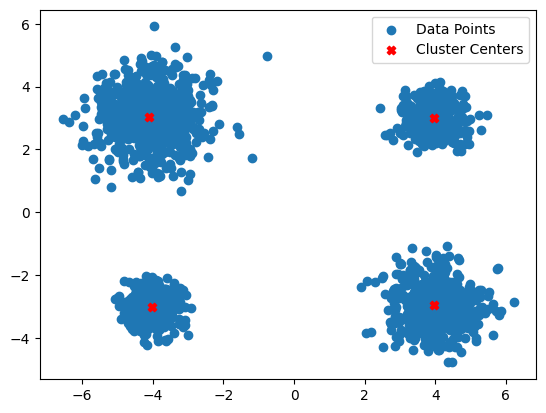

In [17]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = y_to_be_optimized.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()

In [23]:
model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0]

tensor([[0.1991, 0.1423, 0.1202,  ..., 0.2433, 0.0307, 0.3001],
        [0.1923, 0.1528, 0.1076,  ..., 0.2246, 0.0270, 0.2862],
        [0.1931, 0.1409, 0.1141,  ..., 0.2346, 0.0281, 0.2917],
        ...,
        [0.0638, 0.0325, 0.1277,  ..., 0.1277, 0.1813, 0.0937],
        [0.0588, 0.0232, 0.1134,  ..., 0.1230, 0.1556, 0.0947],
        [0.0432, 0.0250, 0.0982,  ..., 0.0968, 0.1546, 0.0695]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [24]:
0.5*torch.cdist(X, y_to_be_optimized, p=2)**2

tensor([[0.1908, 0.1332, 0.1121,  ..., 0.2356, 0.0221, 0.2922],
        [0.1842, 0.1438, 0.0996,  ..., 0.2169, 0.0185, 0.2784],
        [0.1849, 0.1318, 0.1061,  ..., 0.2269, 0.0196, 0.2838],
        ...,
        [0.0570, 0.0251, 0.1211,  ..., 0.1213, 0.1743, 0.0872],
        [0.0519, 0.0156, 0.1067,  ..., 0.1165, 0.1485, 0.0881],
        [0.0364, 0.0176, 0.0915,  ..., 0.0904, 0.1476, 0.0630]],
       device='cuda:0', grad_fn=<MulBackward0>)